In [35]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

# load the dataset
link : https://www.kaggle.com/datasets/jacopoferretti/bbc-articles-dataset


In [36]:
!pip install kaggle

In [37]:
!pip install gensim

In [38]:
!pip install pyLDAvis

In [39]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"buthainaesam","key":"5305c066e6046fb6876eddd2a1e87f71"}'}

In [40]:
!mkdir -p ~/.kaggle

In [41]:
!cp kaggle.json ~/.kaggle/

In [42]:
!chmod 600 ~/.kaggle/kaggle.json

In [43]:
!kaggle datasets download -d jacopoferretti/bbc-articles-dataset

Dataset URL: https://www.kaggle.com/datasets/jacopoferretti/bbc-articles-dataset
License(s): CC0-1.0
bbc-articles-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [44]:
!unzip bbc-articles-dataset.zip


Archive:  bbc-articles-dataset.zip
replace archive (2)/bbc-news-data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace archive/bbc_text_cls.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace bbc_news_text_complexity_summarization.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


# load libraries

In [45]:
import numpy as np
import pandas as pd
import re
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [46]:
nltk.download('stopwords')
stop_words=stopwords.words('english')
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [47]:
df=pd.read_csv('/content/bbc_news_text_complexity_summarization.csv')

# see the data

In [48]:
df.head()

,text,labels,no_sentences,Flesch Reading Ease Score,Dale-Chall Readability Score,text_rank_summary,lsa_summary
0,Ad sales boost Time Warner profit\n\nQuarterly...,business,26,62.17,9.72,It hopes to increase subscribers by offering t...,Its profits were buoyed by one-off gains which...
1,Dollar gains on Greenspan speech\n\nThe dollar...,business,17,65.56,9.09,The dollar has hit its highest level against t...,"""I think the chairman's taking a much more san..."
2,Yukos unit buyer faces loan claim\n\nThe owner...,business,14,69.21,9.66,The owners of embattled Russian oil giant Yuko...,Yukos' owner Menatep Group says it will ask Ro...
3,High fuel prices hit BA's profits\n\nBritish A...,business,24,62.98,9.86,Looking ahead to its full year results to Marc...,"Rod Eddington, BA's chief executive, said the ..."
4,Pernod takeover talk lifts Domecq\n\nShares in...,business,17,70.63,10.23,Reports in the Wall Street Journal and the Fin...,Shares in UK drinks and food firm Allied Domec...


In [49]:
df['labels'].value_counts()

,count
labels,
sport,505
business,503
politics,403
entertainment,369
tech,347


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2127 entries, 0 to 2126
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   text                          2127 non-null   object 
 1   labels                        2127 non-null   object 
 2   no_sentences                  2127 non-null   int64  
 3   Flesch Reading Ease Score     2127 non-null   float64
 4   Dale-Chall Readability Score  2127 non-null   float64
 5   text_rank_summary             2127 non-null   object 
 6   lsa_summary                   2127 non-null   object 
dtypes: float64(2), int64(1), object(4)
memory usage: 116.4+ KB


In [51]:
df.describe()

,no_sentences,Flesch Reading Ease Score,Dale-Chall Readability Score
count,2127.000000,2127.000000,2127.000000
mean,18.968030,63.645548,9.145581
std,13.022952,8.466323,0.823067
min,4.000000,33.410000,6.400000
25%,12.000000,58.210000,8.630000
50%,17.000000,63.430000,9.130000
75%,23.000000,69.310000,9.650000
max,252.000000,87.760000,14.200000


In [52]:
df.isnull().sum()

,0
text,0
labels,0
no_sentences,0
Flesch Reading Ease Score,0
Dale-Chall Readability Score,0
text_rank_summary,0
lsa_summary,0


In [53]:
df.duplicated().sum()

0

# Preprocesing

In [54]:
def preprocess_text(text):
    """
    Preprocess text for topic modeling:
    - Lowercase
    - Remove punctuation & non-letters
    - Tokenize
    - Remove stopwords
    - Lemmatize
    Returns:
      tokens (list) -> for LDA (BoW)
      clean_text (string) -> for NMF (TF-IDF)
    """
    # 1. Lowercase
    text = text.lower()

    # 2. Remove punctuation & non-alphabetic chars
    text = re.sub(r'[^a-z\s]', '', text)

    # 3. Tokenize
    tokens = text.split()

    # Extend default stopwords
    custom_stopwords = set(stopwords.words('english'))
    custom_stopwords.update({
        'say', 'said', 'would', 'could', 'get', 'got', 'make', 'made', 'take', 'took',
        'one', 'two', 'first', 'second', 'also', 'like', 'use', 'used', 'new', 'year'
    })
    # 4. Remove stopwords
    tokens = [word for word in tokens if word not in custom_stopwords]

    # 5. Lemmatize
    doc = nlp(" ".join(tokens))
    lemmas = [token.lemma_ for token in doc if token.lemma_ not in custom_stopwords]

    # Return both
    return {
        "tokens": lemmas,              # for LDA
        "clean_text": " ".join(lemmas) # for NMF
    }

In [55]:
df["processed"] = df["text"].apply(preprocess_text)

# Separate for each model
df["tokens"] = df["processed"].apply(lambda x: x["tokens"])
df["clean_text"] = df["processed"].apply(lambda x: x["clean_text"])


In [56]:
df['tokens'].head(1)

,tokens
0,"[ad, sale, boost, time, warner, profit, quarte..."


In [57]:
df['clean_text'].head(1)

,clean_text
0,ad sale boost time warner profit quarterly pro...


#LDA

In [58]:
from gensim import corpora

# Create dictionary
dictionary = corpora.Dictionary(df["tokens"])

# Filter very rare or very common words
dictionary.filter_extremes(no_below=10, no_above=0.9)

# Create corpus: bag-of-words format
corpus = [dictionary.doc2bow(tokens) for tokens in df["tokens"]]

print("Dictionary size:", len(dictionary))
print("Sample corpus entry:", corpus[0][:5])

Dictionary size: 4291
Sample corpus entry: [(0, 2), (1, 1), (2, 1), (3, 1), (4, 2)]


In [59]:
from gensim.models import LdaModel

# Train LDA
lda_gensim2 = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=5,
    random_state=42,
    passes=50,
    alpha='auto',
    eta='auto',
    per_word_topics=True
)

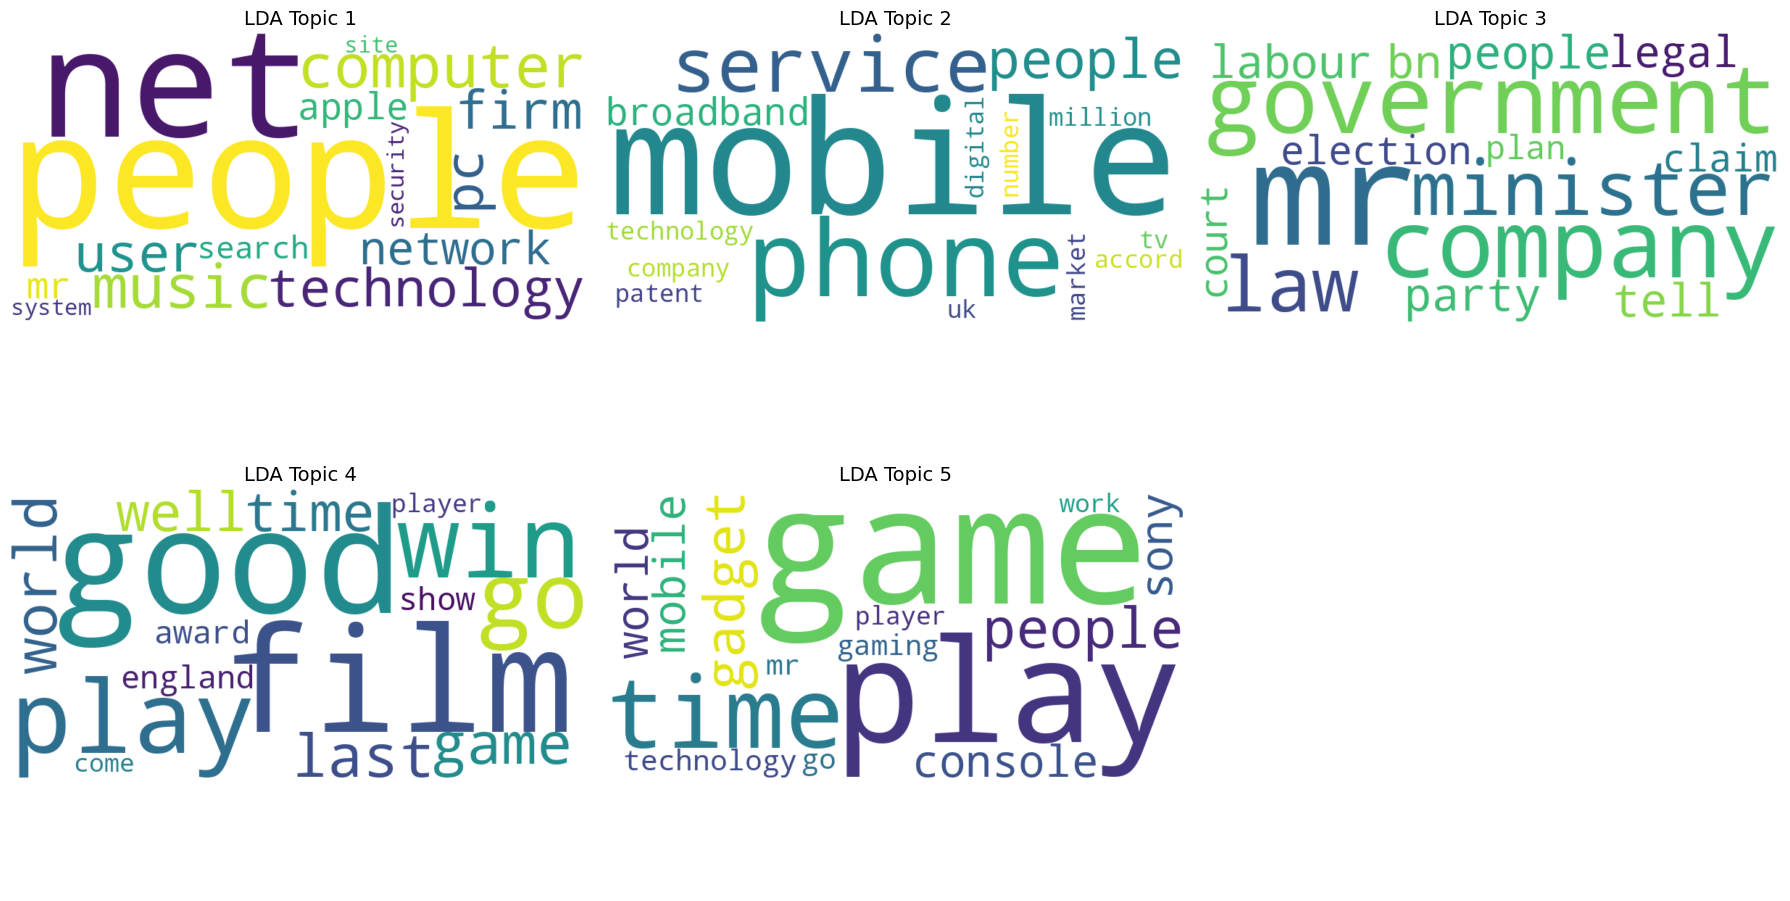

In [60]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# For LDA (Gensim)
for i in range(5):
    # Get top 15 words for topic i
    top_words = [word for word, prob in lda_gensim2.show_topic(i, topn=15)]

    # Create word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(top_words))

    # Plot in the i-th subplot
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f'LDA Topic {i+1}', fontsize=14)

axes[5].axis('off')

plt.tight_layout()
plt.show()

In [67]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

vis = gensimvis.prepare(lda_gensim2, corpus, dictionary)
pyLDAvis.display(vis)



---



# NMF

In [61]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df["clean_text"])

print("TF-IDF shape:", tfidf_matrix.shape)

TF-IDF shape: (2127, 13695)


In [62]:
# Vocabulary size
print("Vocabulary size (TF-IDF):", len(tfidf_vectorizer.get_feature_names_out()))

# Show first 10 words from the vocabulary
print("Sample TF-IDF vocab:", tfidf_vectorizer.get_feature_names_out()[:10])

# Example: first row of TF-IDF
print("First article (TF-IDF values):")
print(tfidf_matrix[0].toarray())

Vocabulary size (TF-IDF): 13695
Sample TF-IDF vocab: ['aaa' 'aaas' 'aac' 'aaron' 'abacus' 'abandon' 'abandonment' 'abate'
 'abba' 'abbas']
First article (TF-IDF values):
[[0. 0. 0. ... 0. 0. 0.]]


In [63]:
from sklearn.decomposition import NMF
nmf = NMF(
    n_components=5,
    random_state=42,
    init='nndsvd'
)
nmf_topics = nmf.fit_transform(tfidf_matrix)

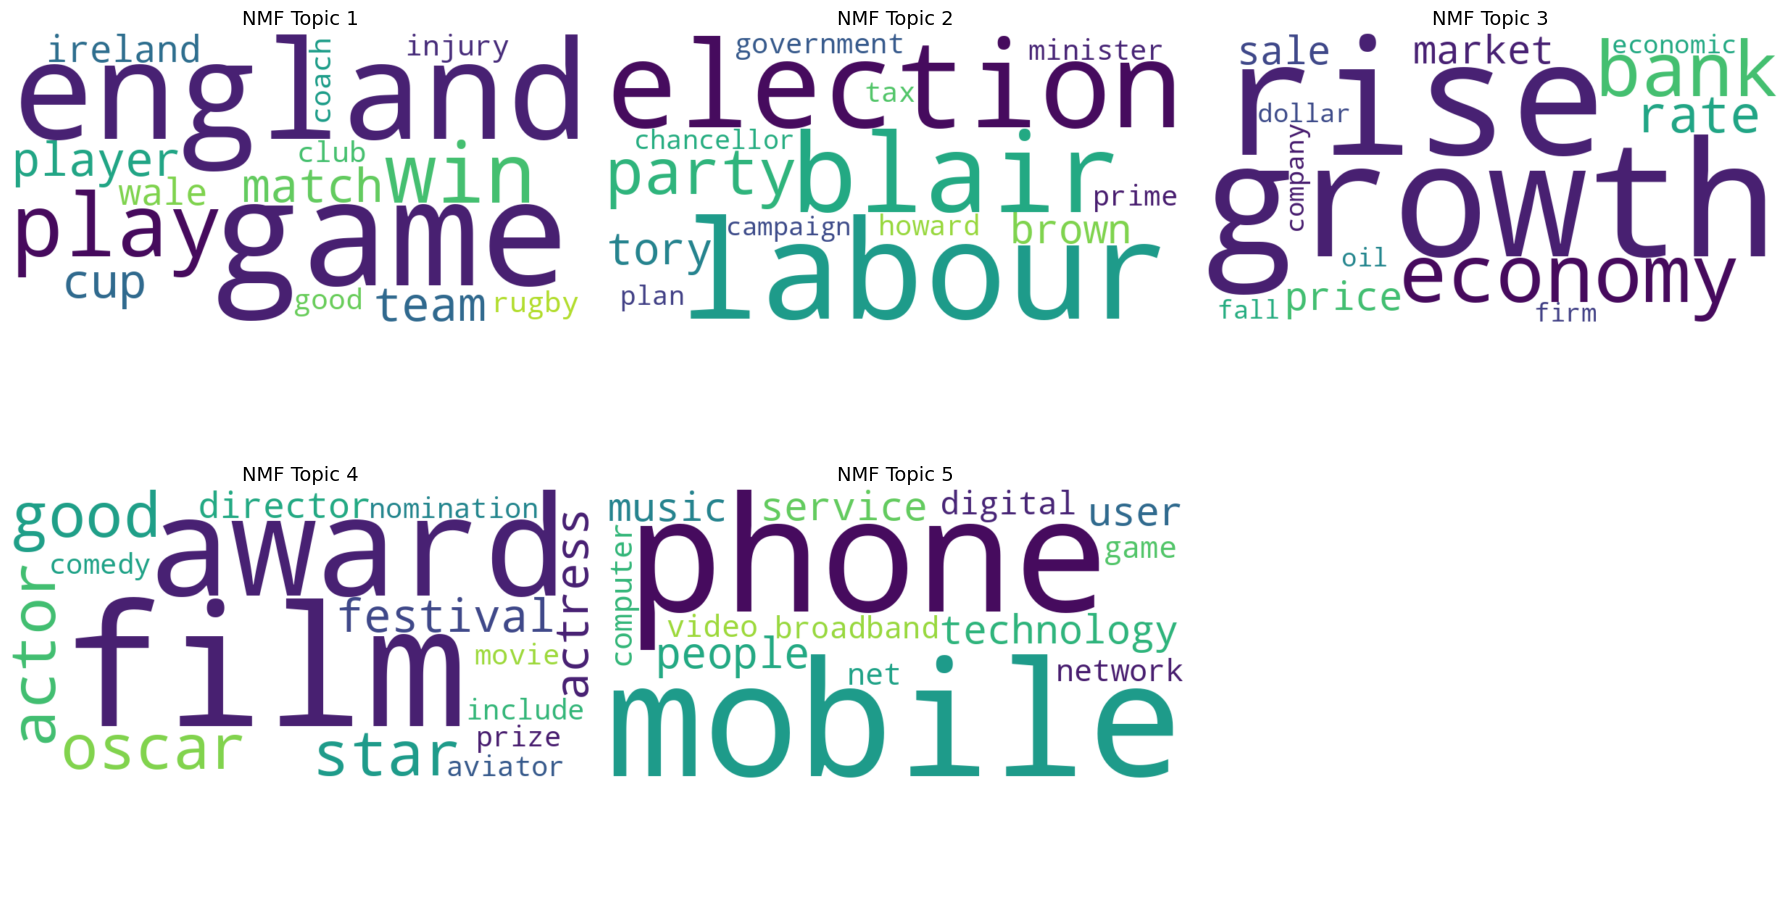

In [64]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Get feature names from TF-IDF vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Generate word cloud for each of the 5 NMF topics
for i in range(5):
    # Get top 15 words for topic i
    top_indices = nmf.components_[i].argsort()[-15:][::-1]
    top_words = [feature_names[j] for j in top_indices if len(feature_names[j]) > 2]

    # Fallback if empty
    if len(top_words) == 0:
        top_words = ["topic", "words", "missing"]

    # Generate word cloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=50,
        random_state=42
    ).generate(' '.join(top_words))

    # Plot in the i-th subplot
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f'NMF Topic {i+1}', fontsize=14)

axes[5].axis('off')

# Final layout and display
plt.tight_layout()
plt.show()

# comparing between LDA and NMF

In [65]:
def display_topics(model, feature_names, n_top_words=10):
    for idx, topic in enumerate(model.components_):
        print(f"\nTopic {idx+1}:")
        print(" | ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

print("\n--- LDA Topics (BoW) ---")
# Show top words per topic
for idx in range(5):
    print(f"\nGensim LDA Topic {idx+1}:")
    print(" | ".join([word for word, prob in lda_gensim2.show_topic(idx, topn=10)]))

print("\n--- NMF Topics (TF-IDF) ---")
display_topics(nmf, tfidf_vectorizer.get_feature_names_out())


--- LDA Topics (BoW) ---

Gensim LDA Topic 1:
people | net | computer | music | technology | user | pc | firm | network | apple

Gensim LDA Topic 2:
mobile | phone | service | people | broadband | technology | uk | million | market | tv

Gensim LDA Topic 3:
mr | government | company | minister | law | people | labour | party | bn | tell

Gensim LDA Topic 4:
good | film | play | win | go | last | world | game | well | time

Gensim LDA Topic 5:
game | play | time | people | gadget | console | world | mobile | sony | technology

--- NMF Topics (TF-IDF) ---

Topic 1:
game | england | play | win | player | match | cup | team | ireland | wale

Topic 2:
mr | labour | election | blair | party | tory | brown | government | minister | howard

Topic 3:
bn | growth | rise | economy | bank | rate | price | sale | market | economic

Topic 4:
film | award | good | star | oscar | actor | festival | actress | director | nomination

Topic 5:
mobile | phone | people | technology | music | service | user

In [66]:
def get_dominant_topic(lda_model, corpus):
    topics = []
    for doc in corpus:
        topic_probs = lda_model.get_document_topics(doc, minimum_probability=0.0)
        dominant_topic = max(topic_probs, key=lambda x: x[1])[0]
        topics.append(dominant_topic)
    return topics

df['lda_topic'] = get_dominant_topic(lda_gensim2, corpus)
df['nmf_topic'] = nmf_topics.argmax(axis=1)  # this part is fine

# Now compare
print("=== LDA vs True Labels ===")
print(pd.crosstab(df['labels'], df['lda_topic']))

print("\n=== NMF vs True Labels ===")
print(pd.crosstab(df['labels'], df['nmf_topic']))

=== LDA vs True Labels ===
lda_topic        0    1    2    3   4
labels                               
business         2  199  296    4   2
entertainment    4    6   32  326   1
politics         0    1  397    4   1
sport            0    0    2  503   0
tech           158   67   35    7  80

=== NMF vs True Labels ===
nmf_topic        0    1    2    3    4
labels                                
business         1   24  461    1   16
entertainment    1    9    5  319   35
politics         3  381   12    1    6
sport          501    0    0    4    0
tech             5    2    3    6  331


# Conclusion

Both LDA and NMF successfully uncovered hidden themes in the BBC news corpus, but **NMF demonstrates clearly superior alignment with true article categories**.

- **NMF excels in topic purity**:  
  - **Sport** is almost perfectly isolated in Topic 0 (**501/503** articles),  
  - **Politics** dominates Topic 1 (**381/403** articles),  
  - **Tech** and **Entertainment** also show strong concentration in Topics 4 and 3.

- **LDA shows significant topic mixing**:  
  - Business, politics, and tech articles are split across Topics 1 and 2,  
  - No single LDA topic cleanly represents "business" or "tech".

 **Why?**  
News articles are **short and keyword-driven** — ideal for **NMF + TF-IDF**, which highlights discriminative terms. LDA’s probabilistic word mixtures are less effective here.

**Final Verdict**:  
> **NMF is the better choice for topic modeling on the BBC dataset.**